## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
converted = df.query('converted == "1"').user_id.nunique()
total = df['user_id'].nunique()

In [7]:
converted/total

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
dontmatch1 = df.query("group == 'treatment' & landing_page != 'new_page'")
dontmatch2 = df.query("group != 'treatment' & landing_page == 'new_page'")
print(dontmatch1.count() + dontmatch2.count())

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64


f. Do any of the rows have missing values?

In [9]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
filter1 = df.query("group == 'treatment' & landing_page == 'new_page'")
filter2 = df.query("group == 'control' & landing_page == 'old_page'")
df2 = filter1.append(filter2)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
#creating a variable for user_id, simplification of code
ids = df2["user_id"]
df2[ids.isin(ids[ids.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
df2[ids.isin(ids[ids.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
#dropping one of the duplicated user_id
df2.drop(2893, inplace=True)

In [17]:
df2[ids.isin(ids[ids.duplicated()])]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
(len(df2[df2['converted'] == 1]))/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
len(df2[(df2['group']=='control') & (df2['converted']==1)])/(len(df2[df2['group'] == 'control']))

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
len(df2[(df2['group']=='treatment') & (df2['converted']==1)])/(len(df2[df2['group'] == 'treatment']))

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
(len(df2[df2['landing_page'] == 'new_page']))/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The new page seems to be performing worse than the old one, but it is too early to conlcude with such conclusion since change aversion factor does exist**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0 -- Pnew - Pold <= 0**


**H1 -- Pnew - Pold > 0** 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
size = df2.shape[0]
df_sample = df2.sample(size)


old_page = df_sample.query('landing_page == "old_page"')
new_page = df_sample.query('landing_page == "new_page"')

In [23]:
Pnew = df2.converted.mean()

Pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
#Pnew and Pold are equal
Pold = df2.converted.mean()

Pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
#this gives the length of rows
len(new_page)

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
#this gives the length of rows
len(old_page)

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
n_new = 145310
n_old = 145274

p_new = df2["converted"].mean()
p_old = df2["converted"].mean()



new_page_converted = np.random.binomial(1,p_new,n_new)
new_page_converted

array([0, 1, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.binomial(1,p_old,n_old)

old_page_converted

array([0, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
diff = new_page_converted.mean()-old_page_converted.mean()
diff

-0.0016818400442122627

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
p_diffs = []
size = df2.shape[0]

for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)
    old_page_converted = np.random.binomial(1,p_old,n_old)
    diff = new_page_converted.mean() - old_page_converted.mean()
    
    p_diffs.append(diff)
p_diffs = np.array(p_diffs)

In [32]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   16.,    74.,   411.,  1321.,  2501.,  2782.,  1953.,   709.,
          210.,    23.]),
 array([-0.00464098, -0.0037559 , -0.00287083, -0.00198575, -0.00110068,
        -0.00021561,  0.00066947,  0.00155454,  0.00243962,  0.00332469,
         0.00420977]),
 <a list of 10 Patch objects>)

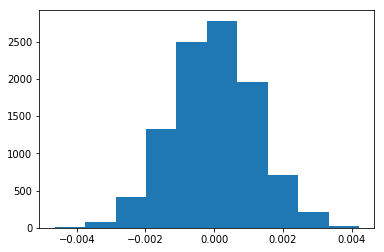

In [33]:
plt.hist(p_diffs)

**Yes, a normal shape, normal distribution since the sample size is sufficiently large**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
(p_diffs > obs_diff).mean()

0.90359999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We computed the P-value. The P-value of 0.904 is large, since its larger than the threshold (0.05) meaning our statistic was likely to support the null hypothesis. Therefore, we failed to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2[(df2.landing_page == 'old_page')&(df2.converted == 1)].shape[0]
convert_new = df2[(df2.landing_page == 'new_page')&(df2.converted == 1)].shape[0]
n_old = df2[(df2.landing_page == 'old_page')].shape[0]
n_new = df2[(df2.landing_page == 'new_page')].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [36]:
convert_old , convert_new

(17489, 17264)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [38]:
zstat,  pvalue = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')

zstat, pvalue

(1.3109241984234394, 0.90505831275902449)

In [39]:
#Critical Values calculated
from scipy.stats import norm
print(norm.ppf(1-(0.05)))

1.64485362695


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**With a sampling distribution, the zstat(1.311) of less than the critical value of (1.644) and the P-value computed remained consistent like in the previou section ( > 0.05), we again fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression, it has only two possible outcomes, binomial probability**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [41]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
log_mod =  sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [45]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-08 16:28 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [46]:
np.exp(-0.0150)

0.98511193960306265

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**The P-value is 0.190. The. p-value here is different, since the hypothesis we're testing here comes from only 2 outcome,Binomial outcome, whether a user converted or not.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more factors can increase the power of the analysis, but only if the sample is large enough. A lot of tests and adjustments needed if we plan on adding variables that arent binomial, therefore it takes a lot of transformation. and if not carefull, multicollinearity can be an issue**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [47]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [48]:
df_new.head(3)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1


In [49]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [50]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
### Fit Your Linear Model And Obtain the Results

log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-08 16:30 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [53]:
np.exp(-0.0408), np.exp(0.0099)

(0.96002111497165088, 1.0099491671175422)

In [54]:
##interaction between page and countries
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'CA', 'UK']])
results3 = log_mod2.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-08 16:31 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [55]:
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.96002111497165088, 1.0099491671175422)

In [56]:
##new variables interaction

df_new['CA_abpage'] = df_new['CA'] * df_new['ab_page']
df_new['UK_abpage'] = df_new['UK'] * df_new['ab_page']

df_new.head(3)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_abpage,UK_abpage
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1


In [57]:
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'CA', 'UK','CA_abpage','UK_abpage']])
results4 = log_mod2.fit()
results4.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-08 16:31 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_abpage    -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_abpage     0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [58]:
np.exp(-0.0206), np.exp(-0.0175), np.exp(-0.0057), np.exp(-0.0469), np.exp(0.0314)

(0.97961073050325054,
 0.9826522356650732,
 0.99431621417843319,
 0.95418281110072622,
 1.0318981806179213)

**After looking at individual factors and also adding an interaction between page and country, the conversion rate remain the same. and also after exponantiating the coefficients, the multiplicative change in the odds being in 1 category is still as expected**  

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0